In [1]:
from pathlib import Path
import sys

notebook_dir = Path.cwd()
others_path = notebook_dir.parent

others_path = others_path.resolve()
if str(others_path) not in sys.path:
    sys.path.append(str(others_path))

import numpy as np
import matplotlib.pyplot as plt

import eos
import kernels
import gaussianprocess
from pqcd.pQCD import pQCD
import prepare_ceft as pc
import prepare_pqcd as pp
import sampling as sam
import anal_helpers as anal
from constants import ns, crust_end, get_phi


In [13]:
n_ceft, cs2_ceft_avg, phi_ceft_sigma, e_ini, p_ini, mu_ini, n_crust, e_crust, p_crust, cs2_crust = pc.make_conditioning_eos()
x_test_end = 20
point_nums = 200


In [14]:
while True:

    cs2_hat, nu_hat, l_hat, X_hat = sam.get_hype_samples()

    kernel = kernels.Kernel('SE', sigma=nu_hat, l=l_hat)


    n_pqcd, cs2_pqcd = pp.get_pqcd(X_hat, size=100) # nsat, unitless

    x_train =  np.concatenate((n_crust[-10:-1],n_ceft, n_pqcd)) #nsat
    cs2_train =  np.concatenate((cs2_crust[-10:-1],cs2_ceft_avg, cs2_pqcd)) # crust excluding last element because it is already in ceft

    phi_pqcd_sigma = np.zeros_like(cs2_pqcd)
    phi_crust_sigma = np.zeros_like(cs2_crust[-10:-1])

    phi_sigma_train = np.concatenate((phi_crust_sigma, phi_ceft_sigma, phi_pqcd_sigma))
    phi_train = get_phi(cs2_train)
    train_noise = phi_sigma_train**2

    x_test = np.linspace(n_ceft[0], x_test_end, point_nums) # number density in nsat, starting val is ending val of n crust, ending val is default 10 nsat


    gp = gaussianprocess.GP(kernel, get_phi(cs2_hat))
    gp.fit(x_train, x_test, phi_train, var_f = train_noise, stabilise=True)

    rng = np.random.default_rng(12345)
    phi_test = rng.multivariate_normal(mean=gp.mean_star, cov=gp.cov_star, size=1)

    phi_test = phi_test.flatten()
    phi_test[0] = get_phi(cs2_crust[-1]) # minor difference in gpr result and actual crust ending so replacing gpr val

    EOS = eos.EosProperties(x_test, phi_test, epsi_0=e_ini, p_0=p_ini, mu_0=mu_ini)
    eos_result = EOS.get_all()

    if pp.check_pqcd_connection(X_hat, eos_result["epsilon"][-1], eos_result["pressure"][-1], x_test_end):
        break

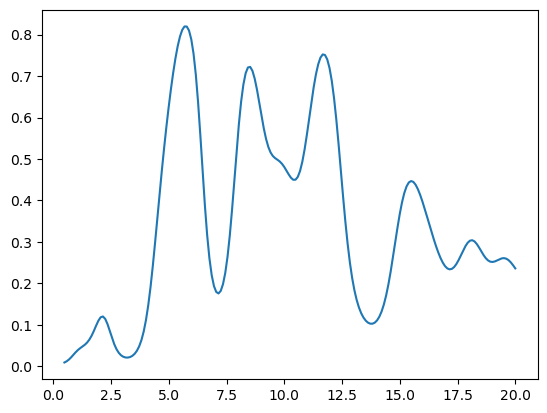

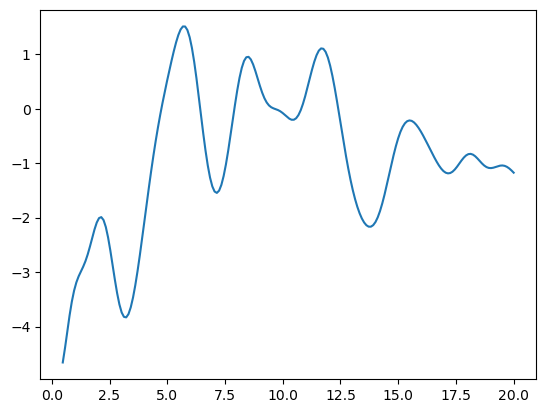

In [15]:
plt.plot(x_test, eos_result["cs2"])
plt.show()

plt.plot(x_test, phi_test)

In [29]:
pp.check_pqcd_connection(X_hat, eos_result["epsilon"][100], eos_result["pressure"][100], x_test[100])


True

In [26]:
np.where(x_test>10)

(array([ 98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
        111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
        124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
        137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149,
        150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
        163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175,
        176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188,
        189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]),)

In [28]:
neg = gp.cov_star[gp.cov_star<0]
neg

array([-1.67298175e-10, -2.37403919e-09, -4.55008120e-09, ...,
       -1.55781809e-14, -1.20851827e-14, -3.25911294e-15])

In [5]:
x_train_ext =  np.concatenate((x_test, n_pqcd)) #nsat
cs2_train_ext =  np.concatenate((cs2_crust[-10:-1],cs2_ceft_avg, cs2_pqcd)) # crust excluding last element because it is already in ceft

phi_train_ext = np.concatenate((phi_test, cs2_pqcd))

x_test_extension = np.linspace(10,20,200)



In [6]:
from scipy.linalg import solve_triangular

gp_ext = gaussianprocess.GP(kernel, phi_train_ext)

K_11 = gp_ext._set_K_11(n_pqcd, stabilise=True)
cov_star_jit = gp.cov_star + 1e-8 * np.eye(gp.cov_star.shape[0])
cov_train = np.zeros((300, 300))
cov_train[:200, :200] = cov_star_jit
cov_train[200:, 200:] = K_11

_, K_12, K_22 = gp_ext._set_kernels(x_train_ext, x_test_extension, stabilise=True, jitter_value=1e-1)


L, alpha = gp_ext._compute_cholesky(cov_train, phi_train_ext, sampling=False)

v = solve_triangular(L, K_12, lower=True, check_finite=False) # 2.1 Line 5


phi_test_extension = (K_12.T @ alpha) # 2.1 Line 4
cov_extension = K_22 - (v.T @ v) # 2.1 Line 6

In [11]:
valid_extensions = []
sam_num = 0

In [12]:
while sam_num < 1:
    rng = np.random.default_rng()

    phi_test_extension_sample = rng.multivariate_normal(mean=phi_test_extension, cov=cov_extension, size=1)

    phi_test_extension_sample = phi_test_extension_sample.flatten()
    phi_test_extension_sample[0] = get_phi(cs2_crust[-1]) # minor difference in gpr result and actual crust ending so replacing gpr val

    EOS_ext = eos.EosProperties(x_test, phi_test, epsi_0=e_ini, p_0=p_ini, mu_0=mu_ini)
    eos_result_ext = EOS_ext.get_all()

    if pp.check_pqcd_connection(X_hat, eos_result_ext["epsilon"][-1], eos_result_ext["pressure"][-1], 20):
        valid_extensions.append(eos_result_ext["cs2"])
        sam_num += 1

valid_extensions = np.asarray(valid_extensions)


KeyboardInterrupt: 

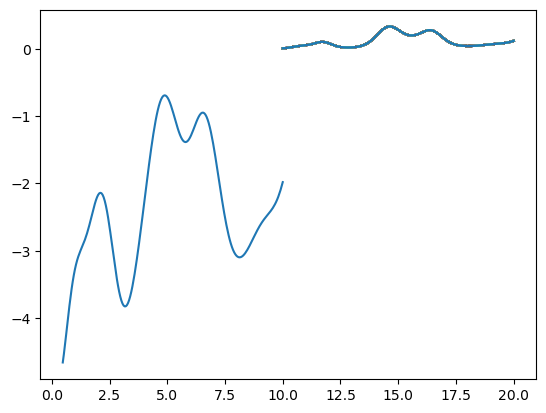

In [54]:
plt.plot(x_test, phi_test)
for phi in valid_extensions:
    plt.plot(x_test_extension, phi)